# Award procedures

In [26]:
import pandas as pd
from os import path
import src.utils.prep as prep 

df = prep.main()


In [6]:
df.groupby("id_award_procedure").count()["amount"].loc[[1, 4, 23, 26]].sum() / df.shape[0] * 100

87.10932561337782

In [ ]:
df.groupby("id_award_procedure").sum()["amount"].loc[[1, 4, 23, 26]].sum() / df["amount"].sum() * 100

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x="id_award_procedure", order=df["id_award_procedure"].value_counts().index, color="tab:blue")
plt.yticks([x*50000 for x in range(1, 7)], [str(x*50)+"k" for x in range(1, 7)])
plt.xlabel("award procedures id")

In [ ]:
data = df.groupby("id_award_procedure").sum()["amount"]
plt.figure(figsize=(12, 8))
sns.barplot(y=data.values, x=data.index, order=data.sort_values(ascending=False).index, color="tab:blue")
plt.xlabel("award procedure id")
plt.ylabel("sum of lot amount")
plt.yticks([x*1e9 for x in range(5)], [str(x)+"G €" for x in range(5)])
plt.show()

In [27]:
abc_cpv_names = {
    33: "medical instruments",
    45: "works",
    85: "healthcare services",
    79: "consulting services "
}
abc_procedure_names = {
    1: "open",
    26: "framework assignment",
    4: "negotiated",
    23: "assigment"
}

procedure_mask = df["id_award_procedure"] == 1
for item in abc_procedure_names:
    procedure_mask += df["id_award_procedure"] == item

cpv_mask = df["cpv"] == 33
for item in abc_cpv_names:
    cpv_mask += df["cpv"] == item

In [10]:
df.groupby("id_award_procedure").count()["amount"].loc[[1, 4, 23, 26]]

id_award_procedure
1       2090
4      15414
23    280842
26     19161
Name: amount, dtype: int64

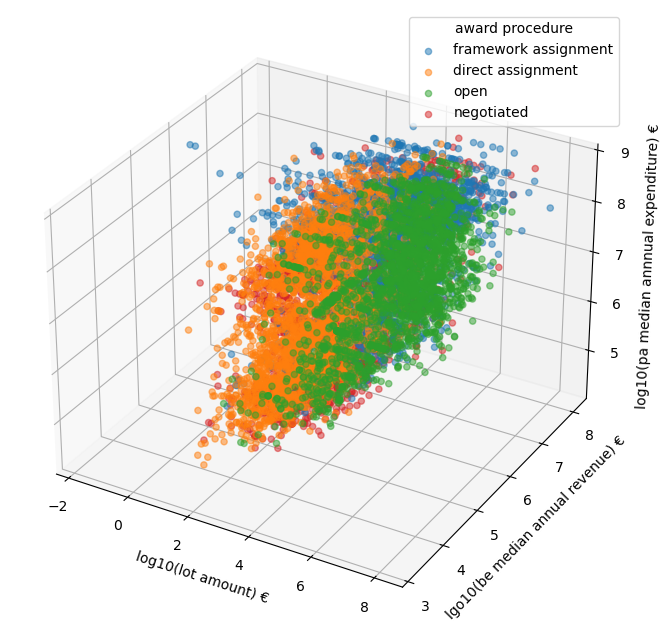

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
data = df[procedure_mask]
# x = data["amount"]
# y = data["pa_med_ann_expenditure"]
# z = data["be_med_ann_revenue"]
labels = ["framework ass.", "direct ass.", "negotiated", "open"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for proc, label, color in zip([26, 23, 4, 1], labels, colors):
    table = data[data["id_award_procedure"] == proc]
    if proc != 1:
        table = table.sample(n=2349, random_state=42)    
    x = np.log10(table["amount"])
    y = np.log10(table["be_med_ann_revenue"])
    z = np.log10(table["pa_med_ann_expenditure"])
    ax.scatter(x, y, z, alpha=.5, label=label)

plt.legend(title="award procedure")
ax.set_xlabel("log10(lot amount) €")
ax.set_zlabel("log10(pa median annnual expenditure) €")
ax.set_ylabel("lgo10(be median annual revenue) €")
plt.show()


0.006361671978092458
0.002280398059145836
0.009430286382952029
0.06577319872551107


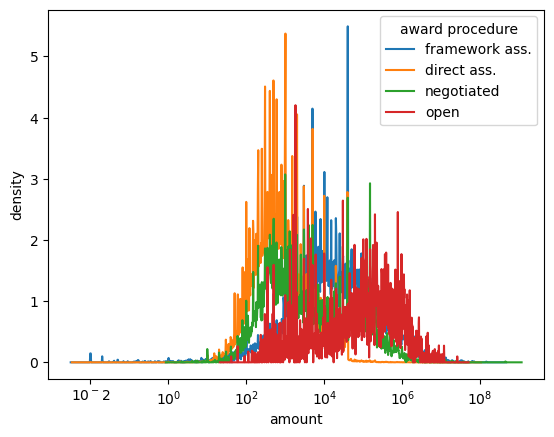

In [57]:
from KDEpy import FFTKDE
import seaborn as sns
labels = ["framework ass.", "direct ass.", "negotiated", "open"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
data = df[procedure_mask]
data = data.replace({"duration": 0}, 1)
for proc, label, color in zip([26, 23, 4, 1], labels, colors):
    X = data[data["id_award_procedure"]==proc]["amount"]
    X = np.log10(X).to_numpy()
    model = FFTKDE(bw="ISJ").fit(X)
    print(model.bw)
    model = FFTKDE(bw=.001).fit(X)
    x, y = model.evaluate()
    plt.plot(x, y, label=label)
    # sns.kdeplot(data=data[data["id_award_procedure"]==proc], x="amount", 
    #              log_scale=True, label=label, color=color, bw_adjust=1)
plt.legend(title="award procedure")
plt.xlabel("amount")
ticks = np.arange(-2, 9, 2)
ticks_labels = [f"$10^{x}$" for x in np.arange(-2, 9, 2)]
plt.xticks(ticks, ticks_labels)
plt.ylabel("density")
plt.show()

0.0011023754503076506
0.0008435744259051652
0.001651793447655261
0.0007623952687873063


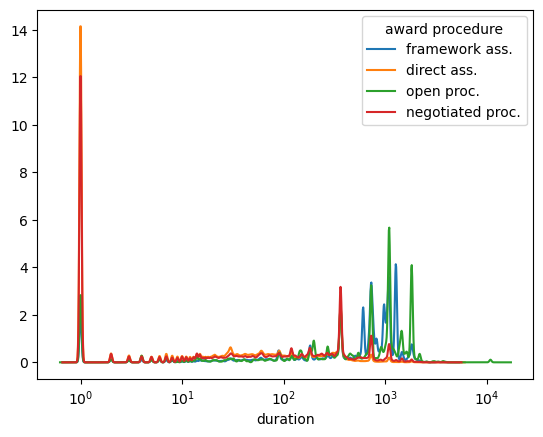

In [14]:
from KDEpy import FFTKDE
import seaborn as sns
labels = ["framework ass.", "direct ass.", "negotiated proc.", "open proc."]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
data = df[procedure_mask]
data = data.replace({"duration": 0}, 1)
for proc, label, color in zip([26, 23, 4, 1], labels, colors):
    X = data[data["id_award_procedure"]==proc]["duration"]
    X = np.log10(X).to_numpy()
    model = FFTKDE(bw="ISJ").fit(X)
    print(model.bw)
    model = FFTKDE(bw=.01).fit(X)
    x, y = model.evaluate()
    plt.plot(x, y, label=label)
    # sns.kdeplot(data=data[data["id_award_procedure"]==proc], x="amount", 
    #              log_scale=True, label=label, color=color, bw_adjust=1)
plt.legend(title="award procedure")
plt.xlabel("duration")
ticks = np.arange(0, 5, 1)
ticks_labels = [f"$10^{x}$" for x in ticks]
plt.xticks(ticks, ticks_labels)
plt.show()

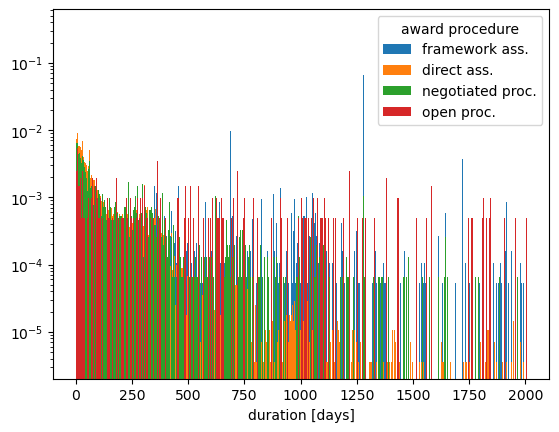

In [53]:
labels = ["framework ass.", "direct ass.", "negotiated proc.", "open proc."]
colors = ["tab:blue", "tab:orange", "tab:red", "tab:green"]
data = df[procedure_mask]
# data = data.replace({"duration": 0}, 1)
for proc, label, color in zip([26, 23, 4, 1], labels, colors):
    X = data[data["id_award_procedure"]==proc]["duration"]
    plt.hist(X, bins=np.arange(0, 2007, 1), label=label, density=True, log=True)
plt.legend(title="award procedure")
plt.xlabel("duration [days]")
ticks = np.arange(0, 5, 1)
ticks_labels = [f"$10^{x}$" for x in ticks]
# plt.xticks(ticks, ticks_labels)
plt.show()

In [45]:
def IQRscale(s: pd.Series) -> pd.Series:
    # scale by interquartile range
    q25, q75 = s.quantile([.25, .75])
    return s / (q75 - q25)

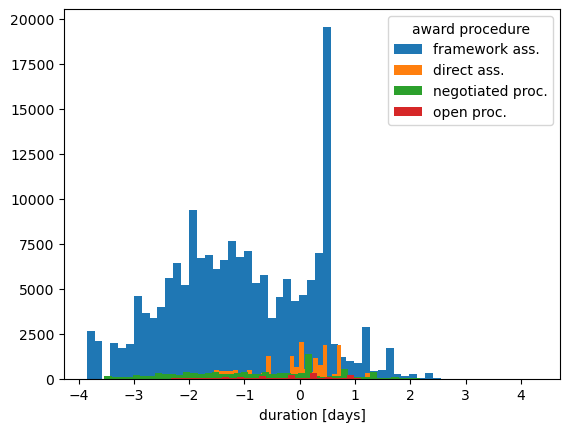

In [51]:
from scipy.stats import boxcox
labels = ["framework ass.", "direct ass.", "negotiated proc.", "open proc."]
colors = ["tab:blue", "tab:orange", "tab:red", "tab:green"]
data = df[procedure_mask]
data = data.replace({"duration": 0}, 1)
data = data[data["duration"] != 1]
for proc, label, color in zip([23, 26, 4, 1], labels, colors):
    X = data[data["id_award_procedure"]==proc]["duration"]
    X = IQRscale(X)
    X = boxcox(X)[0]
    plt.hist(X, bins=50, label=label)
plt.legend(title="award procedure")
plt.xlabel("duration [days]")
ticks = np.arange(0, 5, 1)
ticks_labels = [f"$10^{x}$" for x in ticks]
# plt.xticks(ticks, ticks_labels)
plt.show()

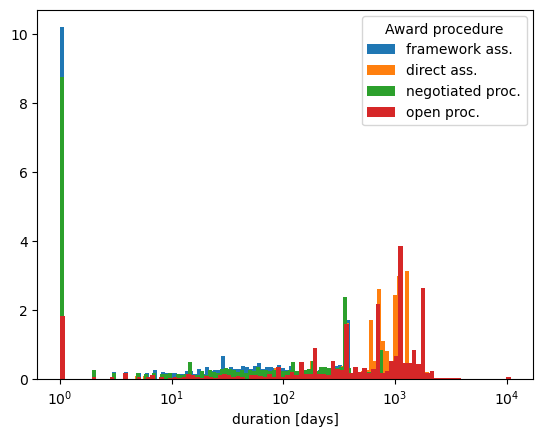

In [20]:

import matplotlib.pyplot as plt
from scipy.stats import boxcox
import numpy as np
labels = ["framework ass.", "direct ass.", "negotiated proc.", "open proc."]
data = df.copy()
# data = data.replace({"duration": 0}, np.mean(data["duration"]))
# data = data[data["duration"] != 0]
data = data.replace({"duration":0}, 1)
for proc, label in zip([23, 26, 4, 1], labels):
    X = data[data["id_award_procedure"]==proc]["duration"]
    X = np.log10(X)
    # X = boxcox(X)[0]
    plt.hist(X, bins=100, label=label, density=True)
plt.legend(title="Award procedure")
plt.xlabel("duration [days]")
ticks = np.arange(0, 5, 1)
labels = [f"$10^{i}$" for i in ticks]
plt.xticks(ticks, labels)
plt.savefig("./images/CPV_duration_kde.png")
plt.show()

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import RobustScaler
from scipy.stats import boxcox

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)
data = df[procedure_mask]
X = data[["duration", "amount", "be_med_ann_revenue", "pa_med_ann_expenditure"]]
X = X.replace({"duration": 0}, X.duration.median())
scaler = RobustScaler(with_centering=False)
X = scaler.fit_transform(X)
# scale only the real-valued columns
for i in range(X.shape[1]):
    X[:, i], _ = boxcox(X[:, i])
X_reduced = PCA(n_components=3).fit_transform(X)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=data["id_award_procedure"],
    s=10,
    alpha=.3
)

ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()


# CPV

In [7]:
import pandas as pd
from os import path
import src.utils.prep as prep 

df = prep.main()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x="cpv", order=df["cpv"].value_counts().index, color="tab:blue")
plt.yticks([x*10000 for x in range(1, 7)], [str(x*10)+"k" for x in range(1, 7)])
plt.xlabel("Common procurement vocabulary divisions")
plt.savefig("./images/CPV_countplot.png")

In [ ]:
df.groupby("cpv").count()["amount"].loc[[33, 45, 65, 85]].sum() / df.shape[0] * 100

In [ ]:
df.groupby("cpv").sum()["amount"].loc[[33, 45, 65, 85]].sum() / df["amount"].sum() * 100

In [ ]:
data = df.groupby("cpv").sum()["amount"]
plt.figure(figsize=(12, 8))
sns.barplot(y=data.values, x=data.index, order=data.sort_values(ascending=False).index, color="tab:blue")
plt.xlabel("Common procurement vocabulary divisions")
plt.ylabel("sum of lot amount")
plt.yticks([x*1e9 for x in range(6)], [str(x)+"G €" for x in range(6)])
plt.savefig("./images/CPV_amount_countplot.png")
plt.show()

In [ ]:
df.groupby("cpv").count()["amount"].loc[[33, 45, 65, 85]]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
long_labels = ["Medical equipments, pharmaceuticals and personal care products", 
    "Construction work", "Public utilities", "Health and social work services"]
labels = ["Medical equipments", "Construction work", "Public utilities", "Health services"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for cpv, label, color in zip([33, 45, 65, 85], labels, colors):
    data = df[df["cpv"] == cpv]
    if cpv != 85:
        data = data.sample(n=100, random_state=42)    
    x = np.log10(data["amount"])
    y = np.log10(data["be_med_ann_revenue"])
    z = np.log10(data["pa_med_ann_expenditure"])
    ax.scatter(x, y, z, alpha=.5, label=label)

plt.legend(title="CPV division")
ax.set_xlabel("log10(lot amount) €")
ax.set_zlabel("log10(pa median annnual expenditure) €")
ax.set_ylabel("lgo10(be median annual revenue) €")
plt.savefig("./images/CPV_scatter.png")
plt.show()



In [6]:
import seaborn as sns
labels = ["Medical equipments", "Construction work", "Public utilities", "Health services"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
data = df
data = data.replace({"duration": 0}, 1)
for cpv, label, color in zip([33, 45, 65, 85], labels, colors):
    sns.kdeplot(data=data[data["cpv"]==cpv], x="duration", 
                 log_scale=True, label=label, color=color)
plt.legend(title="CPV division")
plt.xlabel("duration [days]")
plt.savefig("./images/CPV_duration_kde.png")
plt.show()

NameError: name 'plt' is not defined

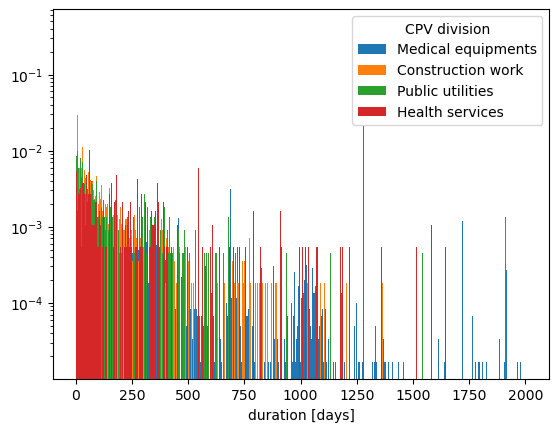

In [10]:
import matplotlib.pyplot as plt
import numpy as np
labels = ["Medical equipments", "Construction work", "Public utilities", "Health services"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
data = df.copy()
# data = data.replace({"duration": 0}, 1)
for cpv, label, color in zip([33, 45, 65, 85], labels, colors):
    X = data[data["cpv"]==cpv]["duration"]
    plt.hist(X, bins=np.arange(0, 2007, 1), label=label, log=True, density=True)
plt.legend(title="CPV division")
plt.xlabel("duration [days]")
plt.savefig("./images/CPV_duration_kde.png")
plt.show()

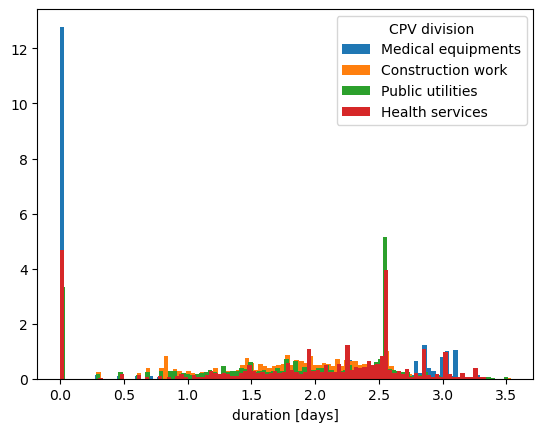

In [14]:
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import numpy as np
labels = ["Medical equipments", "Construction work", "Public utilities", "Health services"]
data = df.copy()
# data = data.replace({"duration": 0}, np.mean(data["duration"]))
# data = data[data["duration"] != 0]
data = data.replace({"duration":0}, 1)
for cpv, label, color in zip([33, 45, 65, 85], labels):
    X = data[data["cpv"]==cpv]["duration"]
    X = np.log10(X)
    # X = boxcox(X)[0]
    plt.hist(X, bins=100, label=label, density=True)
plt.legend(title="CPV division")
plt.xlabel("duration [days]")
plt.savefig("./images/CPV_duration_kde.png")
plt.show()

NameError: name 'plt' is not defined

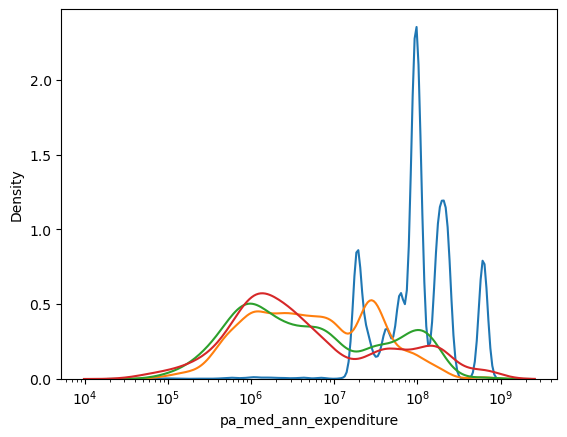

In [4]:
import seaborn as sns
labels = ["Medical equipments", "Construction work", "Public utilities", "Health services"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
data = df
data = data.replace({"duration": 0}, 1)
for cpv, label, color in zip([33, 45, 65, 85], labels, colors):
    sns.kdeplot(data=data[data["cpv"]==cpv], x="pa_med_ann_expenditure", 
                 log_scale=True, label=label, color=color)
plt.legend(title="CPV division")
plt.xlabel("Contracting entity median annual expenditure [€]")
plt.savefig("./images/CPV_expenditure_kde.png")
plt.show()

In [ ]:
import seaborn as sns
labels = ["Medical equipments", "Construction work", "Public utilities", "Health services"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
data = df
data = data.replace({"duration": 0}, 1)
for cpv, label, color in zip([33, 45, 65, 85], labels, colors):
    sns.kdeplot(data=data[data["cpv"]==cpv], x="be_med_ann_revenue", 
                 log_scale=True, label=label, color=color)
plt.legend(title="CPV division")
plt.xlabel("Business entity median annual revenue [€]")
plt.savefig("./images/CPV_revenue_kde.png")
plt.show()

In [ ]:
import seaborn as sns
labels = ["Medical equipments", "Construction work", "Public utilities", "Health services"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
data = df
data = data.replace({"duration": 0}, 1)
for cpv, label, color in zip([33, 45, 65, 85], labels, colors):
    sns.kdeplot(data=data[data["cpv"]==cpv], x="amount", 
                 log_scale=True, label=label, color=color)
plt.legend(title="CPV division")
plt.xlabel("Lot amount [€]")
plt.savefig("./images/CPV_amount_kde.png")
plt.show()

# proc cpv joint distribution

In [ ]:
# marginal distribution 
data = df[df["id_award_procedure"].isin([1, 4, 23, 26])]
data = data[data["cpv"].isin([33, 45, 65, 85])]
marginal = data.groupby(["id_award_procedure", "cpv"]).size()
marginal = marginal.unstack()
marginal = marginal / marginal.sum().sum()
marginal = marginal.round(4)
marginal
marginal.to_csv("./miscellanea/cpv_proc_marginals.csv", sep="&")

# time dimension

In [2]:
import src.utils.prep as prep 
df = prep.main()
features = ["amount", "pa_med_ann_expenditure", "be_med_ann_revenue", "duration"]
d16 = df[df.start_date.dt.year == 2016]
d17 = df[df.start_date.dt.year == 2017]
d18 = df[df.start_date.dt.year == 2018]
d16 = d16[features]
d17 = d17[features]
d18 = d18[features]

In [ ]:
# import numpy as np
# import plotly.express as px
# fig = px.scatter_3d(d16, x="amount", y="be_med_ann_revenue", 
#     z="pa_med_ann_expenditure", log_x=True, log_y=True, log_z=True)
# centroid = np.log10(d16.replace(0, 1)).mean(axis=0)
# # px.scatter_3d(centroid[0], centroid[1], centroid[2])
# fig.update_traces(marker={'size': 1})
# fig.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
data = d16.sample(n=1000, random_state=42)
x = np.log10(data["amount"])
y = np.log10(data["be_med_ann_revenue"])
z = np.log10(data["pa_med_ann_expenditure"])
ax.scatter(x, y, z, alpha=.3)
centroid = np.log10(d16.replace(0, 1)).mean(axis=0)
ax.scatter(centroid[0], centroid[1], centroid[2], color="red", s=50)
centroid = np.log10(d16.median(axis=0))
ax.scatter(centroid[0], centroid[1], centroid[2], color="green", s=50)

ax.set_xlabel("log10(lot amount) €")
ax.set_zlabel("log10(pa median annnual expenditure) €")
ax.set_ylabel("lgo10(be median annual revenue) €")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
for data, label, color in zip([d16, d17, d18], [2016, 2017, 2018], ["tab:blue", "tab:green", "tab:red"]):
    centroid = np.log10(data.median(axis=0))
    ax.scatter(centroid[0], centroid[1], centroid[2])
    data = data.sample(n=1000, random_state=42)
    x = np.log10(data["amount"])
    y = np.log10(data["be_med_ann_revenue"])
    z = np.log10(data["pa_med_ann_expenditure"])
    ax.scatter(x, y, z, alpha=.3, label=label, color=color)

plt.legend(title="Year")
ax.set_xlabel("log10(lot amount) €")
ax.set_zlabel("log10(pa median annnual expenditure) €")
ax.set_ylabel("lgo10(be median annual revenue) €")
plt.show()

In [ ]:
# compute the distance metric over the normalized dataset
year_idx = dict()
for year in [2016, 2017, 2018]:
    year_idx[year] = df.index[df.start_date.dt.year == year].to_list()

In [ ]:
from sklearn.preprocessing import RobustScaler, StandardScaler
data = df[features]
data = data.replace(0, 1) #  duration 0 -> duration 1
data = np.log10(data)
# data = RobustScaler().fit_transform(data)
scaler = RobustScaler()
data = scaler.fit_transform(data)

centroids = list()
for year in [2016, 2017, 2018]:
    centroids.append(data[year_idx[year]].mean(axis=0))
centroids = np.stack(centroids)
# squared euclidean distance metrix on log scale
np.round(np.sum(np.square(centroids.T - np.reshape(centroids, (3, -1, 1))), axis=1), 4)

In [ ]:
inv_centroids = scaler.inverse_transform(centroids)
inv_centroids = inv_centroids ** 10

In [ ]:
np.arange(2.5, 3.1, .1)

In [ ]:
plt.plot(inv_centroids[:, 2], inv_centroids[:, 0])
for i, year in zip([0, 1, 2], [2016, 2017, 2018]):
    plt.scatter(inv_centroids[i, 2], inv_centroids[i, 0], label=year)
plt.legend()

plt.ylabel("amount")
ticks = range(65, 90, 5)
plt.yticks([x*1000 for x in ticks], ["€ " + str(x)+"k" for x in ticks])

plt.xlabel("business entity median annual specific revenue")
ticks = np.arange(2.5, 3.1, .1)
plt.xticks([x*1e7 for x in ticks], ["€ " + str(round(x, 1))+"M" for x in ticks])

plt.show()


In [ ]:
plt.plot(inv_centroids[:, 1], inv_centroids[:, 0])
for i, year in zip([0, 1, 2], [2016, 2017, 2018]):
    plt.scatter(inv_centroids[i, 1], inv_centroids[i, 0], label=year)
plt.legend()

plt.ylabel("amount")
ticks = range(65, 95, 5)
plt.yticks([x*1000 for x in ticks], ["€ " + str(x)+"k" for x in ticks])

plt.xlabel("contracting entity median annual expenditure")
ticks = np.arange(1.4, 2, .1)
plt.xticks([x*1e8 for x in ticks], ["€ " + str(round(x, 1))+"G" for x in ticks])

plt.show()

In [ ]:
plt.plot(inv_centroids[:, 3], inv_centroids[:, 0])
for i, year in zip([0, 1, 2], [2016, 2017, 2018]):
    plt.scatter(inv_centroids[i, 3], inv_centroids[i, 0], label=year)
plt.legend()

plt.ylabel("amount")
ticks = range(65, 95, 5)
plt.yticks([x*1000 for x in ticks], ["€ " + str(x)+"k" for x in ticks])

plt.xlabel("duration [days]")
# ticks = np.arange(1.4, 2, .1)
# plt.xticks([x*1e8 for x in ticks], ["€ " + str(round(x, 1))+"G" for x in ticks])

plt.show()

In [ ]:
plt.bar(["2016", "2017", "2018"], inv_centroids[:, 0])
ticks = range(2, 9, 2)
plt.yticks([x*10000 for x in ticks], ["€ " + str(x*10)+"k" for x in ticks])
plt.ylabel("contract lot amount")
plt.show()

## Kullback-Leibler divergence

In [1]:
import src.utils.prep as prep 
df = prep.main()

In [2]:
features = ["amount", "pa_med_ann_expenditure", "be_med_ann_revenue", "duration"]
data = dict()
for year in [16, 17, 18]:
    data[year] = df[df.start_date.dt.year == int("20"+str(year))]
    data[year] = data[year][features]

In [3]:
from sklearn.preprocessing import RobustScaler
import numpy as np
scaler = RobustScaler()
for year in [16, 17, 18]:
    data[year] = data[year].replace(0, 1)
    data[year] = np.log10(data[year])
    data[year] = scaler.fit_transform(data[year])

In [4]:
import numpy as np
from KDEpy import FFTKDE
for i in range(len(features)):
    for year in [16, 17, 18]:
        model = FFTKDE(bw="ISJ").fit(data[year][:, i])
        print(year, i,  model.bw)

16 0 0.00336195773474137
17 0 0.0026702657843265297
18 0 0.002395032655933798
16 1 0.0011863543126283175
17 1 0.0013364711716541584
18 1 0.0008217880954068692
16 2 0.003821742901993294
17 2 0.0038804994034253577
18 2 0.004583449393748266
16 3 0.00042612849977961094
17 3 0.00031250260201442625
18 3 0.00042630872322634955


In [133]:
FFTKDE._available_kernels.keys()

dict_keys(['gaussian', 'exponential', 'box', 'tri', 'epa', 'biweight', 'triweight', 'tricube', 'cosine'])

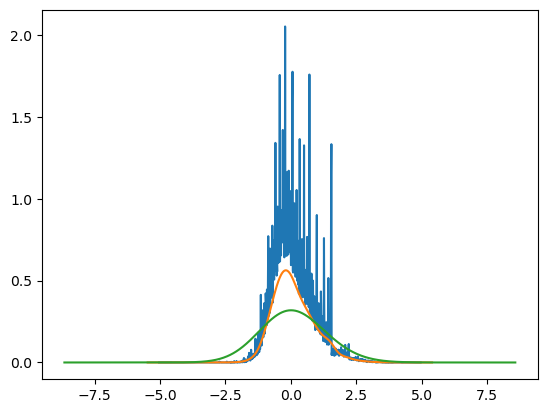

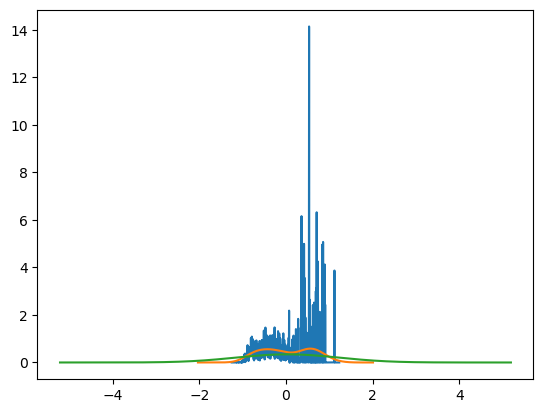

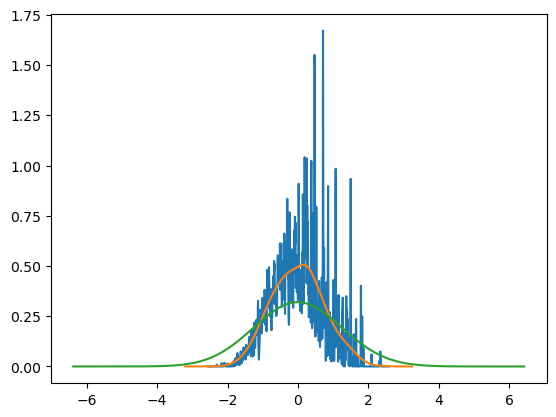

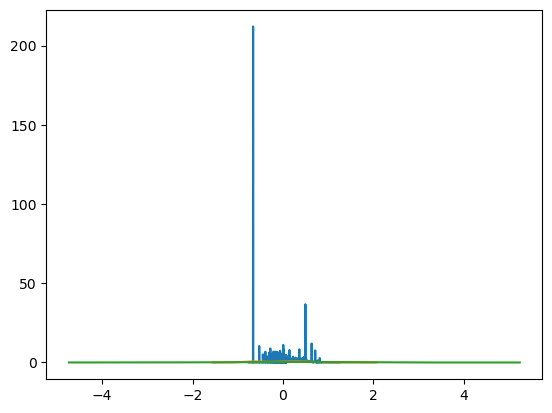

In [44]:
import matplotlib.pyplot as plt
for i in range(4):
    model = FFTKDE(bw="ISJ").fit(data[year][:,i]) 
    x, y = model.evaluate()
    plt.plot(x, y, label=model.bw)
    model = FFTKDE(bw=0.2).fit(data[year][:,i])
    x, y = model.evaluate()
    plt.plot(x, y, label=model.bw)
    model = FFTKDE(bw=1).fit(data[year][:,i])
    x, y = model.evaluate()
    plt.plot(x, y, label=model.bw)
    plt.show()

In [42]:
data[year][:, 0][np.where((data[year][:, 0] > -2.5) & (data[year][:, 0] < 3))]


array([ 0.60745969,  0.39919811, -0.35731164, ...,  0.71054415,
        1.26949603,  0.66645052])

In [32]:
from KDEpy import FFTKDE
year = 16
# print(grid.shape)
# print(data[year].shape)
model = dict()
model[year] = FFTKDE(bw=.5).fit(data[year])
N = 10**2
_, y16 = model[year].evaluate((N, N, N, N))
print(np.max(y16))
year = 17
model[year] = FFTKDE(bw=.5).fit(data[year])
_, y17 = model[year].evaluate((N, N, N, N))
print(np.max(y17))
np.sum(y16 * np.log(y16)) - np.sum(y16 * np.log(y17))

0.06041178870553602
0.05677042370291049


13481.738661252675

In [136]:
from sklearn.neighbors import KernelDensity
kde = dict()
for year in [16, 17, 18]: 
    kde[year] = KernelDensity(bandwidth=0.1)
    kde[year].fit(data[year])

# e poi come creo gli stessi input?

In [ ]:
np.arange(10**-2, 10**8)

In [137]:
log16 = kde[16].score_samples(data[16])

In [23]:
q17on16 = kde[17].score_samples(data[16])

In [24]:
import numpy as np
np.sum(np.exp(log16) * log16) - np.sum(np.exp(log16) * q17on16)

0.023431225980845606

In [29]:
from datetime import date
with open("KL_results.txt", "a") as f:
    f.write(str(date.today()))

In [27]:

for year in [16, 17, 18]:
    for y in [16, 17, 18]:
        with open("KL_results.txt", "a") as f:
            s = "P" + str(year) + ",Q" + str(y) + ",KL:" + "result" + "\n"
            f.write(s)


In [ ]:
# KL is not symmetric
for year in [16, 17, 18]:
    for y in [16, 17, 18]:
        if year != y:
            logP = kde[year].score_samples(data[year])
            logQ = kde[y].score_samples(data[year])
            

In [ ]:
q18on16 = kde[18].score_samples(data[16])

# generate subset

In [8]:
import src.utils.prep as prep 
df = prep.main()

In [9]:
features_to_csv = ["id_lotto", "amount", "duration", "start_date", 
    "id_award_procedure", "id_pa", "uber_forma_giuridica", "id_be","object", 
    "be_med_ann_revenue", "pa_med_ann_expenditure"]

In [10]:
data = df.copy()

In [11]:
entity = "id_be"

# data = data[data.join(data.groupby(entity).size().rename("be_size"), on=entity)["be_size"] > 10]
# remove the entity with contract with the same amount
# boxcox does not apply if array entries are all the same 

# data = data[data["id_be"] != 283012] 
# print(data.shape, df.shape)

In [13]:
from scipy import stats
# print the entities with all the same values
exceptions = list()
for name, group in data.groupby(entity):
    # tab[name] = np.std(stats.boxcox(group["amount"])[0])
    try: 
        stats.boxcox(group["amount"])[0]
    except ValueError:
        exceptions.append(name)
        continue

In [17]:
mask = data[entity] == exceptions[0]
for e in exceptions[1:]:
    mask += data[entity] == e


49

In [7]:
from scipy import stats
import numpy as np
def boxcox(s) -> np.array:
    return stats.boxcox(s)[0]
# eventualmente, Kolmogorov-Smirnov test to verify the normality assumption
# data = data[["id_be", "id_pa", "amount"]]
# scale by IQR
q25, q50, q75 = data["amount"].quantile([.25, .5, .75])
data.loc[:, "amount"] = (data["amount"]) / (q75 - q25)
# data["amount"] = boxcox(data["amount"])[0] farlo qui funziona peggio

# boxcox non funziona se i valori in array sono tutti uguali
# apply boxcox transform to amounts grouped by entity
entity = "id_be"
data["amount"] = data.groupby(entity)["amount"].transform(boxcox)

In [38]:
import pandas as pd
from scipy import stats
def stdconfint(df: pd.DataFrame) -> pd.DataFrame:
    n = len(df)
    std = np.std(df["amount"], ddof=1)
    upper = np.sqrt((n - 1) / stats.chi2.ppf(alpha / 2, n - 1)) * std
    lower = np.sqrt((n - 1) / stats.chi2.ppf((1 - alpha) / 2, n - 1)) * std
    return round(upper - lower, 4)

data = data.join(data.groupby(entity)["amount"].std().rename(entity.strip("id") + "std"), on=entity)
data = data.join(data.groupby(entity).apply(stdconfint).rename(entity.strip("id") + "stdconfint"), on=entity)
# data["stdconfint"].max()


ValueError: columns overlap but no suffix specified: Index(['std'], dtype='object')

In [44]:
data =data.drop(columns=["std"])

In [46]:
data = data.join(data.groupby(entity)["amount"].std().rename("3std"), on=entity)
data["std"] = 3 * data["3std"]

In [1]:
data["amount"] > data["std"]

NameError: name 'data' is not defined

In [37]:
data.groupby(entity)["amount"].std().rename("std").sort_values(ascending=False)

id_be
111060    189.235556
410608    114.626623
371590    112.830827
434778     42.112718
3501       22.801804
110761     18.189815
388035     18.116594
110214     16.395993
89126      15.953386
329503      9.412308
Name: std, dtype: float64

In [11]:
s = data.groupby(entity).size().rename(entity.strip("id_") + "_N")
data = data.join(s, on=entity)

In [7]:
# for each entity, compute the confidence intervals 

# VARIANCE EXAMPLE
arr = [8.69, 8.15, 9.25, 9.45, 8.96, 8.65, 8.43, 8.79, 8.63]

alpha = 0.05               # significance level = 5%
n = len(arr)               # sample sizes
s2 = np.var(arr, ddof=1)   # sample variance
df = n - 1                 # degrees of freedom

upper = (n - 1) * s2 / stats.chi2.ppf(alpha / 2, df)
lower = (n - 1) * s2 / stats.chi2.ppf(1 - alpha / 2, df)

In [ ]:
#  SAMPLE
subset = data.groupby(["id_award_procedure", data.start_date.dt.year], group_keys=False).apply(lambda x: x.sample(50, random_state=42))
# SELECT ONLY THOSE HAVING amount > 3sigma or amount < -3sigma

StopIteration: 

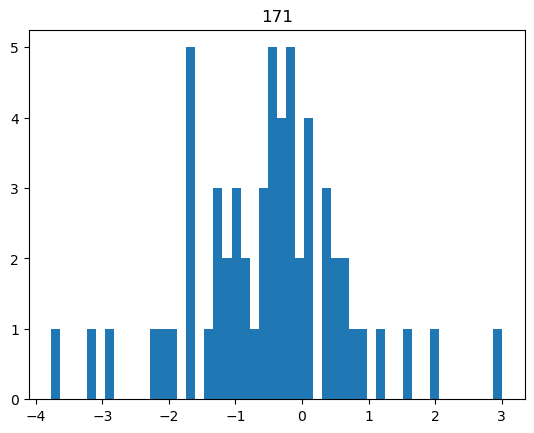

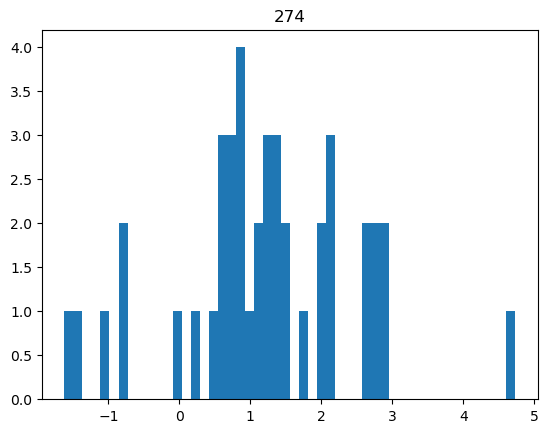

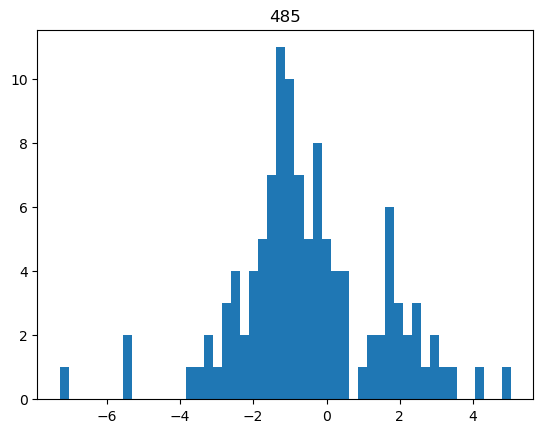

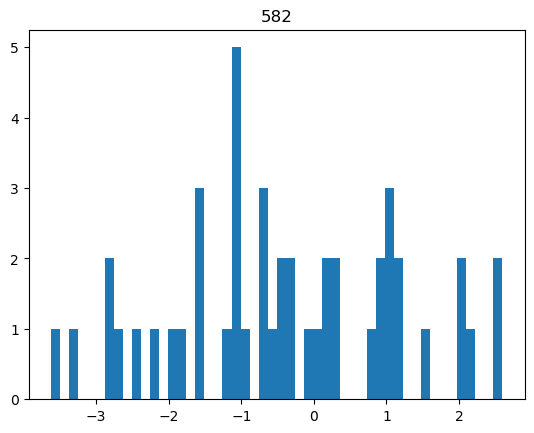

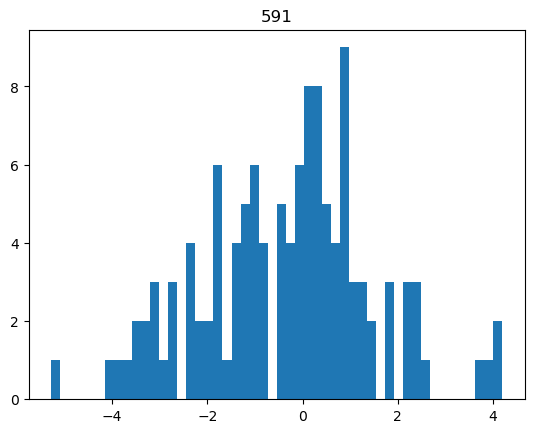

In [71]:
# check results
import matplotlib.pyplot as plt
count = 0
for name, group in data.groupby(entity):
    count += 1
    plt.figure()
    plt.hist(group["amount"], bins=50)
    plt.title(name)
    # print(group["amount"])
    if count > 4:
        raise StopIteration

va tenuto per plottare qualche distribuzione, benché sia meglio plottare il test di Kolmorov Smirnoff

In [ ]:
import matplotlib.pyplot as plt
entity = "id_be"
data = data[["id_be", "id_pa", "amount"]]
q25, q50, q75 = data["amount"].quantile([.25, .5, .75])
data.loc[:, "amount"] = (data["amount"]) / (q75 - q25)
# data["amount"] = boxcox(data["amount"])[0] farlo qui funziona peggio

# boxcox(data["amount"])
count = 0
for name, group in data.groupby(entity):
    count += 1
    plt.figure()
    plt.hist(boxcox(group["amount"])[0], bins=50)
    plt.title(name)
    # print(group["amount"])
    if count > 4:
        raise StopIteration

In [120]:
from scipy import stats
def boxcox(s) -> np.array:
    s = s.values
    return stats.boxcox(s)[0]
# eventualmente, Kolmogorov-Smirnov test to verify the normality assumption
data = df[["id_be", "id_pa", "amount"]]
q25, q50, q75 = data["amount"].quantile([.25, .5, .75])
data.loc[:, "amount"] = (data["amount"]) / (q75 - q25)
# data["amount"] = boxcox(data["amount"])[0] farlo qui funziona peggio


# df.groupby(entity)["amount"].transform(boxcox) # non rieso a farlo funzionare
entity = "id_be"
tab = dict()
for name, group in data.groupby(entity):
    # tab[name] = np.std(stats.boxcox(group["amount"])[0])
    try: 
        boxcox(group["amount"])[0]
    except ValueError:
        print(name)

pd.Series(tab)



/var/folders/yj/96_1_7qn6ml45v0p1z0ns7180000gn/T/ipykernel_15756/2788857732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "amount"] = (data["amount"]) / (q75 - q25)


119647


ValueError: 

In [123]:
data[data["id_be"] == 119647]

,id_be,id_pa,amount
56838,119647,2992,5.91716


# miscellanea

In [1]:
import pandas as pd
import numpy as np
subset = pd.read_csv("data/aperta.csv")


In [10]:
import pandas as pd
import numpy as np
subset = pd.read_csv("data/subset_aperta.csv")
np.sum(subset[["be_probOut", "pa_probOut", "duration_probOut"]], axis=0)

be_probOut           65
pa_probOut           68
duration_probOut    104
dtype: int64

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
df = prep.main()
t = pd.concat([df.groupby("cpv")["amount"].sum().sort_values(ascending=False), df.groupby("id_scelta_contraente").size().rename("lot_count")], axis=1)
data = (t["amount"]/ t["lot_count"]).sort_values(ascending=False)

coords = range(len(data))
height = data.values

plt.figure(figsize=(16, 8))
plt.bar(coords, t["amount"], tick_label=data.index)

In [ ]:
pd.read_csv("synData6July/tipi_procedure.csv")

# GMM viz

In [ ]:
import src.utils.prep as prep 
df = prep.main()

In [ ]:
from sklearn import mixture
import numpy as np
from matplotlib.colors import LogNorm
X_train = df[df["id_award_procedure"] == 1]
X_train = np.array(X_train[["amount", "be_med_ann_revenue"]])
X_train = np.log10(X_train)
clf = mixture.GaussianMixture(n_components=2, covariance_type="full")
clf.fit(X_train)
x = np.linspace(1, 8)
y = np.linspace(2, 9)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

plt.figure(figsize=(12, 8))
CS = plt.contour(
    X, Y, Z, norm=LogNorm(vmin=1.0, vmax=50), levels=np.logspace(0, 3, 20)
)
# CB = plt.colorbar(CS, shrink=0.8, extend="both")
plt.scatter(X_train[:, 0], X_train[:, 1], alpha=.5)
plt.xlabel("log10(amount) [euro]")
plt.ylabel("log10(business entity median annual specific revenue) [euro]")
plt.title("open procedure lots, Veneto, 2016-2018")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
data = df[df["id_award_procedure"] == 1]
plt.figure(figsize=(12, 8))
plt.scatter(data["amount"], data["be_med_ann_revenue"], alpha=.3)
plt.loglog()
plt.xlabel("amount [euro]")
plt.ylabel("business entity median annual revenue [euro]")
plt.title("open procedure lots, Veneto, 2016-2018")


In [ ]:
t = df[["be_med_ann_revenue", "min_nlots_id_be"]]
t = t[~t.duplicated()]
t["magnitude"] = np.floor(np.log10(t["be_med_ann_revenue"])).astype("int")

In [ ]:
from matplotlib.patches import Patch
N = 26
M = len(set(t["magnitude"]))
data = pd.DataFrame.from_dict({1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0}, "index")
for n in range(2, N):
    tab = t[t["min_nlots_id_be"] >= n]
    tab = tab.groupby("magnitude").size().rename(n)
    data = pd.concat([data, tab], axis=1)
data = data.drop(columns=[0])
data = np.nan_to_num(np.array(data))
# data = data / np.sum(data, axis=0)

fig, ax = plt.subplots(figsize=(12, 8))
labels = list(range(2, N))
print(data.shape)
for i in range(data.shape[0]):
    ax.bar(labels, data[i, :], label=i+1)

custom_patches = [
    Patch(color="tab:blue"),
    Patch(color="tab:orange"),
    Patch(color="tab:green"),
    Patch(color="tab:red"),
    Patch(color="tab:purple"),
    Patch(color="tab:brown"),
    Patch(color="tab:pink"),
    Patch(color="tab:grey"),
]
custom_labels = [
    "€ [1, 10]",
    "€ [10, $10^2$]",
    "€ [$10^2$, $10^3$]",
    "€ [$10^3$, $10^4$]",
    "€ [$10^4$, $10^5$]",
    "€ [$10^5$, $10^6$]",
    "€ [$10^6$, $10^7$]",
    "€ [$10^7$, $10^8$]"
]
plt.legend(custom_patches, custom_labels, title="median annual revenue")

plt.xlabel("number of awarded lots in a year by a single business entity")
plt.ylabel("number of business entity")
plt.show()

In [ ]:
df.columns

In [ ]:
N = 26
M = len(set(t["magnitude"]))
data = pd.DataFrame.from_dict({1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0}, "index")
for n in range(2, N):
    tab = t[t["min_nlots_id_be"] == n]
    tab = tab.groupby("magnitude").size().rename(n)
    data = pd.concat([data, tab], axis=1)
data = data.drop(columns=[0])

# outliers

In [ ]:
import src.utils.prep as prep 
df = prep.main()

In [ ]:
df["OUTLIER"] = df["OUTLIER"].map({True: -1, False: 1})

In [ ]:
df["OUTLIER"] = df["OUTLIER"].fillna(0)

In [ ]:
df[df["id_award_procedure"] == 1].shape

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
data = df[df["id_award_procedure"] == 1]

# for category, color, label in zip([0, -1, 1], ["gold", "red", "blue"], ["unknown", "outlier", "inlier"]):
for category, color, label in zip([-1, 1, 0], ["red", "blue", "gold"], ["outlier", "inlier", "not verified"]):
    d = data[data["OUTLIER"] == category]
    x = np.log10(d["amount"])
    y = np.log10(d["pa_med_ann_expenditure"])
    z = np.log10(d["be_med_ann_revenue"])
    if color == "gold":
        ax.scatter(x, y, z, c=color, alpha=.3, label=label)
    else:
        ax.scatter(x, y, z, c=color, alpha=1, label=label)
# legend = ax.legend(*s.legend_elements())
ax.legend()

ax.set_xlabel("log10(lot amount) €")
ax.set_ylabel("log10(pa median annnual expenditure) €")
ax.set_zlabel("lgo10(be median annual revenue) €")
# ax.set_title("open procedure")
plt.show()

In [ ]:
df[df["id_award_procedure"] == 1]

In [ ]:
import pandas as pd
results = pd.read_csv("output/281022-105529_aperta_oc-svm/aperta_oc-svm.csv")
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
data = results

x = np.log10(data["amount"])
y = np.log10(data["pa_med_ann_expenditure"])
z = np.log10(data["be_med_ann_revenue"])
s = ax.scatter(x, y, z, c=data["score"], alpha=.5)
# legend = ax.legend(*s.legend_elements())
# ax.add_artist(legend) 

ax.set_xlabel("log10(lot amount) €")
ax.set_ylabel("log10(pa median annnual expenditure) €")
ax.set_zlabel("lgo10(be median annual revenue) €")
plt.show()

In [ ]:
results = pd.read_csv("output/281022-105529_aperta_oc-svm/aperta_oc-svm.csv")
results["OUTLIER"] = results["OUTLIER"].map({True:-1, False:1})
results["OUTLIER"] = results["OUTLIER"].fillna(0)
results["OUTLIER"] = results["OUTLIER"].astype("int")

In [ ]:
results[results["OUTLIER"] == results["score"]][["OUTLIER", "score"]]
results[results["OUTLIER"] == -1][["OUTLIER", "score"]]

In [ ]:
sum(results["OUTLIER"] == -1)

In [ ]:
results = pd.read_csv("output/281022-112536_aperta_kde/aperta_kde.csv")
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
data = results

x = np.log10(data["amount"])
y = np.log10(data["pa_med_ann_expenditure"])
z = np.log10(data["be_med_ann_revenue"])
s = ax.scatter(x, y, z, c=data["score"], alpha=.5)
legend = ax.legend(*s.legend_elements())
ax.add_artist(legend) 

ax.set_xlabel("log10(lot amount) €")
ax.set_ylabel("log10(pa median annnual expenditure) €")
ax.set_zlabel("lgo10(be median annual revenue) €")
plt.show()

In [ ]:
results["OUTLIER"] = results["OUTLIER"].map({True:-1, False:1})
results["OUTLIER"] = results["OUTLIER"].fillna(0)
results["OUTLIER"] = results["OUTLIER"].astype("int")

In [ ]:
results["flag"] = results["score"] < -10
results["flag"] = results.flag.map({True: -1, False: 1})
results[results["OUTLIER"] == results["flag"]][["OUTLIER", "flag"]]
results[results["OUTLIER"] == -1][["OUTLIER", "flag"]]

In [ ]:
np.sum(results["OUTLIER"] == -1)

In [ ]:
# MERGE CHECKED OUTLIERS FROM GOOGLE SHEETS
import pandas as pd
outliers_checked = pd.read_csv("output/checked_outliers.csv", index_col=0)
df.merge(outliers_checked, how="left", on="id_lotto").sort_values("OUTLIER", ascending=False)

# check subset outliers

In [1]:
import pandas as pd
INPUTDIR = "data"
df = pd.read_csv(os.path.join(INPUTDIR, "subset.csv"))
df["start_date"] = pd.to_datetime(df["start_date"])

In [2]:
df.shape

(200, 16)

In [3]:
df["probOut"] = "inlier"

df["probOut"][df["be_probOut"] == True] = "business entity"
df["probOut"][df["pa_probOut"] == True] = "contracting entity"
df["probOut"][df["duration_probOut"] == True] = "duration"

/var/folders/yj/96_1_7qn6ml45v0p1z0ns7180000gn/T/ipykernel_29691/1402384895.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["probOut"][df["be_probOut"] == True] = "business entity"
/var/folders/yj/96_1_7qn6ml45v0p1z0ns7180000gn/T/ipykernel_29691/1402384895.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["probOut"][df["pa_probOut"] == True] = "contracting entity"
/var/folders/yj/96_1_7qn6ml45v0p1z0ns7180000gn/T/ipykernel_29691/1402384895.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [4]:
import plotly.express as px
px.scatter_3d(df, x="amount", y="be_med_ann_revenue", z="pa_med_ann_expenditure", 
    color="probOut", log_x=True, log_y=True, log_z=True)


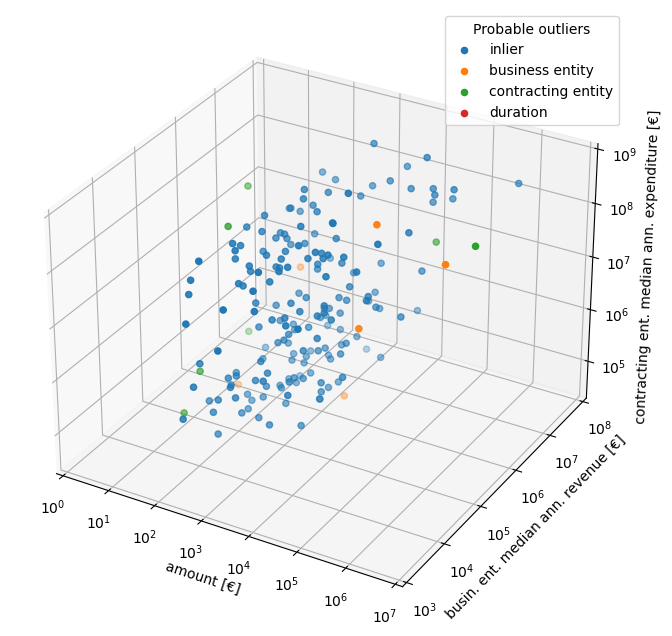

In [5]:
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')

labels = ["inlier", "business entity", "contracting entity", "duration"]
colors = ["tab:blue", "tab:red", "tab:green", "tab:orange"]
for label, color in zip(labels, colors):
    data = df[df["probOut"] == label]
    x = np.log10(data["amount"])
    y = np.log10(data["be_med_ann_revenue"])
    z = np.log10(data["pa_med_ann_expenditure"])
    ax.scatter(x, y, z, label=label)

ax.set_xlabel("amount [€]")
ticks = np.arange(1-1, 7+1, 1)
labels = [f"$10^{i}$" for i in ticks]
ax.set_xticks(ticks=ticks, labels=labels)

ax.set_ylabel("busin. ent. median ann. revenue [€]")
ticks = np.arange(4-1, 8+1, 1)
labels = [f"$10^{i}$" for i in ticks]
ax.set_yticks(ticks=ticks, labels=labels)

ax.set_zlabel("contracting ent. median ann. expenditure [€]")
ticks = np.arange(5, 9+1, 1)
labels = [f"$10^{i}$" for i in ticks]
ax.set_zticks(ticks=ticks, labels=labels)

plt.legend(title="Probable outliers")
plt.show()

In [1]:
import pandas as pd
pd.read_csv("data/subset_aperta.csv")

,amount,be_med_ann_revenue,be_probOut,be_std,pa_med_ann_expenditure,pa_probOut,pa_std,duration,object,start_date,id_award_procedure,id_pa,id_be,id_lotto,outlier
0,417576.0,5.694970e+06,False,2.034983,8.730653e+06,True,2.081468,1095,Procedura aperta affidamento servizio copertur...,2016-01-01,1,7650,87001,7535791,False
1,140.0,1.285934e+05,False,2.887846,9.590546e+07,False,2.290389,699,Servizio Approvvigionamenti - Procedura aperta...,2016-07-01,1,2997,91049,3201105,False
2,1000.0,2.166317e+05,False,1.435130,2.787300e+05,False,1.420367,6,TRANSFER DA E PER AEROPORTO DI BERGAMOP VIAGGI...,2016-03-06,1,25560,220066,275150094,False
3,400000.0,1.692747e+06,False,2.204406,1.322456e+08,True,1.887313,668,"LAVORI DI MANUTENZIONE ELETTRICA ORDINARIA , S...",2016-03-03,1,33034,312297,733609,False
4,348000.0,1.324921e+06,False,2.394436,2.043933e+07,False,1.482288,1382,FORNITURA DI AUTOMEZZI ED ATTREZZATURE PER L'A...,2016-10-18,1,2404,92860,3899346,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,4900.0,5.592178e+04,False,1.161551,3.638499e+06,False,1.881108,455,GARA A PROCEDURA APERTA TRAMITE MEPA PER L'AFF...,2018-10-02,1,6907,94546,4347734,False
197,479000.0,1.559545e+06,False,2.001546,3.378291e+05,True,1.912503,1064,SERVIZI SCOLASTICI: DETERMINAZIONE A CONTRARRE...,2018-09-01,1,11990,94699,7867017,False
198,417800.0,6.126586e+05,True,1.467616,7.026953e+06,True,1.882082,828,AGGIUDICAZIONE DEFINITIVA CON VALORE DI EFFICA...,2018-09-25,1,11344,100599,15125896,False
199,68559.0,2.893615e+06,False,2.454898,3.656800e+07,False,2.166053,91,Subaffidamento servizi TPL settore extraurbano...,2018-06-10,1,31568,3261,9620196,False
